# Table of Contents
 <p><div class="lev1"><a href="#評価指標"><span class="toc-item-num">1&nbsp;&nbsp;</span>評価指標</a></div>

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
import numpy as np

%matplotlib inline

In [2]:
# blobsの中心をクラスタ数に基づいて自動生成する
cluster= 5
step = 10
samples = 1000
centers = [(x,x) for x in range(0, step*cluster, step)]
print(centers)

[(0, 0), (10, 10), (20, 20), (30, 30), (40, 40)]


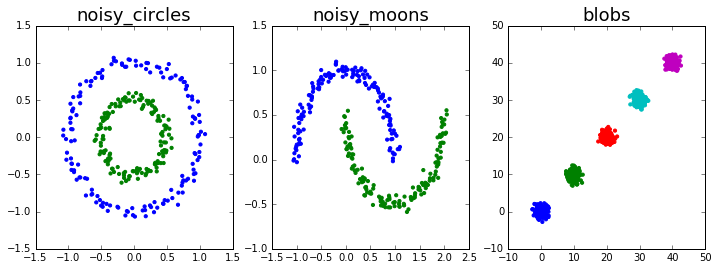

In [3]:
n_samples = 300
np.random.seed(0)

#blobs = datasets.make_blobs(n_samples=n_samples, random_state=8, cluster_std=3.0, centers=[(5,5),(-5,-5)])
blobs = datasets.make_blobs(n_samples=samples, centers=centers, cluster_std=1.0)
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
# no_structure = np.random.rand(n_samples, 2), None

#datasets_list = [noisy_circles, noisy_moons, blobs]
datasets_name = ["noisy_circles", "noisy_moons", "blobs"]


datasets_list = [
#   (StandardScaler().fit_transform(X), y) for X,y in [noisy_circles, noisy_moons, blobs]
   (X, y) for X,y in [noisy_circles, noisy_moons, blobs]
]

for dataset, dataset_name in zip(datasets_list, datasets_name):
    X, Y = dataset
    with open(dataset_name+".dat", "w") as f:
        for x, y in zip(X, Y):
            f.write(str(y)+","+str(x[0])+","+str(x[1])+"\r\n")
            
            

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

plt.figure(figsize=(len(datasets_list) * 2 + 6, 4))
#plt.subplots_adjust(left=.00, right=.98, bottom=.001, top=.96, wspace=.05,
#                    hspace=.01)


plot_num = 1
for i_dataset, (dataset, dataset_name) in enumerate(zip(datasets_list, datasets_name)):
    X, y = dataset
    # normalize dataset for easier parameter selection
    #X = StandardScaler().fit_transform(X)

    plt.subplot(1, len(datasets_list), plot_num)
    plt.title(datasets_name[i_dataset], size=18)
    plt.scatter(X[:, 0], X[:, 1], color=colors[y].tolist(), s=10)
    plot_num += 1
plt.savefig("data.png")

In [11]:
# データセットの分析
print("dataset")
print(X.shape)
print(X)

dataset
(300, 2)
[[ -5.05109000e-01  -1.27592521e+00]
 [ -1.84554120e+00  -1.39783490e+00]
 [ -1.95546351e+00  -1.88071234e+00]
 [ -3.07128577e-01   1.06914358e+00]
 [ -1.23693363e+00   2.68507051e-01]
 [  5.85366190e-01  -5.52365245e-01]
 [  1.50658837e-01   1.69648807e-03]
 [  1.09166368e+00   1.48142015e+00]
 [  1.73233897e+00   5.13599042e-01]
 [ -4.49152595e-01   3.30820380e-01]
 [  1.13233697e+00   1.70277594e-02]
 [  4.87243024e-01  -1.65087486e-01]
 [ -4.87408310e-01  -6.69478926e-02]
 [  1.04861335e+00  -1.44190256e-01]
 [  1.29241129e+00   1.60721147e+00]
 [  3.64271441e-01   7.99306645e-01]
 [  7.83902479e-01   6.35725973e-01]
 [ -1.35824129e+00  -1.88735818e+00]
 [ -2.47240916e-01  -1.25206667e-01]
 [  1.02277103e+00   6.04756453e-01]
 [ -9.61656745e-01  -1.86947940e-01]
 [ -5.50408592e-02  -2.89612756e-01]
 [  5.76171757e-01   5.38196824e-01]
 [  7.34325516e-01   6.16431991e-01]
 [  6.12130961e-01   9.85145209e-01]
 [  6.03513774e-01   1.05227485e+00]
 [  1.05634993e+00  -

In [21]:
import json

from embedded_jubatus import Clustering
from jubatus.clustering.types import WeightedDatum
from jubatus.clustering.types import WeightedIndex
from jubatus.clustering.types import IndexedPoint
from jubatus.common import Datum


CONFIG = {
    'method': 'kmeans',
    'parameter': {
        'k' : 2,
        'seed' : 0,
    },
    'compressor_parameter': {
        'bucket_size': 2,
    },
    'compressor_method' : 'simple',
    'converter': {
        'num_filter_types': {},
        'num_filter_rules': [],
        'string_filter_types': {},
        'string_filter_rules': [],
        'num_types': {},
        'num_rules': [
            {'key': '*', 'type': 'num'}
        ],
        'string_types': {},
        'string_rules': [
            {'key': '*', 'type': 'space',
             'sample_weight': 'bin', 'global_weight': 'bin'}
        ]
    },
}

client = Clustering(CONFIG)

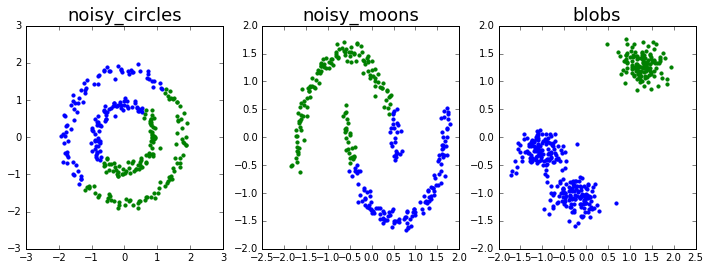

In [22]:
plot_num = 1
plt.figure(figsize=(len(datasets_list) * 2 + 6, 4))
for i_dataset, (dataset, dataset_name) in enumerate(zip(datasets_list, datasets_name)):
    plt.subplot(1, len(datasets_list), plot_num)

    plt.title(datasets_name[i_dataset], size=18)
    
    X, y = dataset
    # normalize dataset for easier parameter selection
    #X = StandardScaler().fit_transform(X)

    i = 0
    client.clear()
    for row in X:
        client.push([IndexedPoint(str(i), Datum({'x' : row[0], 'y' : row[1]}))])
        i += 1
#    print("{0} push done.".format(datasets_name[i_dataset]))
    
    clusters = client.get_core_members_light()
        
    y = 0
    for cluster in clusters:
        for weighted_index in cluster:           
            plt.scatter(X[int(weighted_index.id), 0], X[int(weighted_index.id), 1], color=colors[y].tolist(), s=10)
        y += 1
    plot_num += 1
plt.savefig("kmeans.png")

In [14]:
CONFIG['method'] = 'gmm'
client = Clustering(CONFIG)

KeyboardInterrupt: 

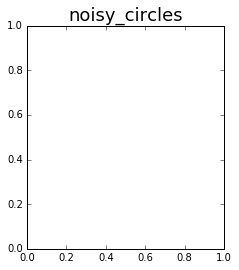

In [15]:
plot_num = 1
plt.figure(figsize=(len(datasets_list) * 2 + 6, 4))
for i_dataset, (dataset, dataset_name) in enumerate(zip(datasets_list, datasets_name)):
    plt.subplot(1, len(datasets_list), plot_num)

    plt.title(datasets_name[i_dataset], size=18)
    
    X, y = dataset
    # normalize dataset for easier parameter selection
    #X = StandardScaler().fit_transform(X)

    i = 0
    client.clear()
    for row in X:
        client.push([IndexedPoint(str(i), Datum({'x' : row[0], 'y' : row[1]}))])
        i += 1
    print("{0} push done.".format(datasets_name[i_dataset]))
    
    clusters = client.get_core_members_light()
        
    y = 0
    for cluster in clusters:
        for weighted_index in cluster:           
            plt.scatter(X[int(weighted_index.id), 0], X[int(weighted_index.id), 1], color=colors[y].tolist(), s=10)
        y += 1
    plot_num += 1
plt.savefig("gmm.png")

In [87]:
CONFIG['method'] = 'dbscan'
if 'k' in CONFIG['parameter']:
    del(CONFIG['parameter']['k'])
if 'seed' in CONFIG['parameter']:
    del(CONFIG['parameter']['seed'])
CONFIG['parameter']['eps'] = 1.0
CONFIG['parameter']['min_core_point'] = 2
#print(CONFIG)
client = Clustering(CONFIG)

noisy_circles push done.
noisy_moons push done.
blobs push done.


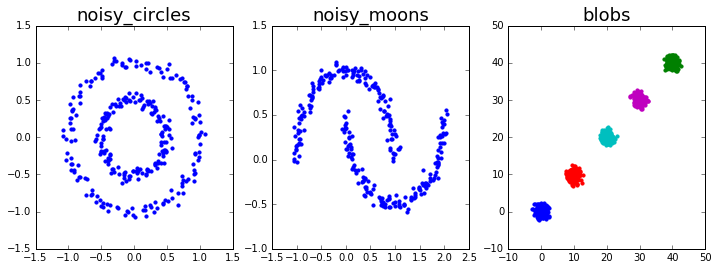

In [88]:
plot_num = 1
plt.figure(figsize=(len(datasets_list) * 2 + 6, 4))
for i_dataset, (dataset, dataset_name) in enumerate(zip(datasets_list, datasets_name)):
    plt.subplot(1, len(datasets_list), plot_num)

    plt.title(datasets_name[i_dataset], size=18)
    
    X, y = dataset
    # normalize dataset for easier parameter selection
    #X = StandardScaler().fit_transform(X)

    i = 0
    client.clear()
    for row in X:
        client.push([IndexedPoint(str(i), Datum({'x' : row[0], 'y' : row[1]}))])
        i += 1
    print("{0} push done.".format(datasets_name[i_dataset]))
    
    clusters = client.get_core_members_light()
        
    y = 0
    for cluster in clusters:
        for weighted_index in cluster:           
            plt.scatter(X[int(weighted_index.id), 0], X[int(weighted_index.id), 1], color=colors[y].tolist(), s=10)
        y += 1
    plot_num += 1
plt.savefig("dbscan.png")

# 評価指標
http://y-uti.hatenablog.jp/entry/2014/01/19/133936


In [12]:
from sklearn import metrics
labels_true = [0, 0, 0, 1, 1, 1]
labels_pred = [0, 0, 1, 1, 2, 2]
labels_pred_all_correct = [0, 0, 0, 1, 1, 1]
labels_pred_alternative = [4, 4, 4, 5, 5, 5]
labels_pred2 = [0, 0, 0, 6, 6, 6]

print("adjusted rand index")
print(metrics.adjusted_rand_score(labels_true, labels_pred))
print(metrics.adjusted_rand_score(labels_true, labels_pred_all_correct))
print(metrics.adjusted_rand_score(labels_true, labels_pred_alternative))
print(metrics.adjusted_rand_score(labels_true, labels_pred2))

print("Mutual information based score")
print(metrics.adjusted_mutual_info_score(labels_true, labels_pred))
print(metrics.adjusted_mutual_info_score(labels_true, labels_pred_all_correct))
print(metrics.adjusted_mutual_info_score(labels_true, labels_pred_alternative))
print(metrics.adjusted_mutual_info_score(labels_true, labels_pred2))

adjusted rand index
0.242424242424
1.0
1.0
1.0
Mutual information based score
0.225042310598
1.0
1.0
1.0
